In [1]:
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import pandas as pd
from enum import Enum
import graphviz as gv
from langchain.prompts.chat import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.output_parsers import PydanticOutputParser
from langchain.chains import LLMChain, ConversationChain
from langchain.memory import ConversationBufferMemory

load_dotenv()

True

In [2]:
llm = ChatOpenAI(model_name="gpt-4")

# A Simple Prompt
For this example, we will ask `ChatGPT` to create a small village in a particular location, in a particular year, and with a specified number of inhabitants.

In [4]:
PROMPT_FORMAT = """
Create a village in {location} in the year {year}. Describe {population} villagers along with their family relations to one another.
"""

simple_prompt = PromptTemplate.from_template(PROMPT_FORMAT)
simple_prompt_with_values = simple_prompt.format_prompt(
    location="Yorkshire, England",
    year=900,
    population=10,
)

In [76]:
response = llm(simple_prompt_with_values.to_messages())
response.content

"Village Name: Ainsty \n\n1) Eadric the Elder: The unofficial leader of Ainsty, Eadric is a man of 60 winters, with a grizzled beard and weathered face. He is known for his wisdom and strength. Eadric was once a respected warrior, but now he spends his time guiding the villagers and settling disputes. He is the father to Ceolwulf and grandfather to Edith.\n\n2) Ceolwulf: The son of Eadric, Ceolwulf, 35, has taken up his father's mantle as the strongest warrior in the village. He is married to Aethelflaed and they have a daughter, Edith. Ceolwulf is respected for his bravery and skill in hunting.\n\n3) Aethelflaed: Wife to Ceolwulf and daughter-in-law to Eadric, Aethelflaed, 32, is known for her beauty and her skill in herbal medicine. She often helps villagers with their ailments and is also a master at weaving.\n\n4) Edith: The bright-eyed, 10-year-old daughter of Ceolwulf and Aethelflaed, Edith is a curious and adventurous child. She is adored by her grandfather, Eadric, who often te

# A Simple Prompt with Parsed Outputs

## Pydantic: A Model and Parser

In [5]:
class Villager(BaseModel):
    name: str
    age: int
    sex: str
    occupation: str
    ethnicity: str


class RelationshipType(Enum):
    SPOUSE_OF = "spouse of"
    PARENT_OF = "parent of"


class Relationship(BaseModel):
    subject_name: str = Field(
        "the subject of the relationship (e.g. Jane, subject, is a sibling of Sam, object.)"
    )
    object_name: str = Field(
        "the object of the relationship (e.g. Jane, subject, is a sibling of Sam, object.)"
    )
    type: RelationshipType


class Village(BaseModel):
    name: str
    description: str
    county: str
    year: int
    villagers: list[Villager]
    relationships: list[Relationship]


pydantic_parser = PydanticOutputParser(pydantic_object=Village)

### Add a "format instructions" parameter to the prompt.

In [6]:
PROMPT_FORMAT_FOR_PARSING = (
    PROMPT_FORMAT
    + "\n{format_instructions}\nThe output should not deviate from this format in any way."
)
PROMPT_FORMAT_FOR_PARSING

'\nCreate a village in {location} in the year {year}. Describe {population} villagers along with their family relations to one another.\n\n{format_instructions}\nThe output should not deviate from this format in any way.'

In [7]:
prompt = PromptTemplate.from_template(PROMPT_FORMAT_FOR_PARSING)
prompt_with_values = prompt.format_prompt(
    location="Jórvík",
    year=900,
    population=10,
    format_instructions=pydantic_parser.get_format_instructions(),
)

In [8]:
response_to_parse = llm(prompt_with_values.to_messages())

In [65]:
village = pydantic_parser.parse(response_to_parse.content)
village

Village(name='Jórvík Hamlet', description='A small Viking settlement situated near the river Ouse, known for its craftsmen and farmers', county='Jórvík', year=900, villagers=[Villager(name='Erik', age=45, sex='Male', occupation='Blacksmith', ethnicity='Norse'), Villager(name='Astrid', age=43, sex='Female', occupation='Weaver', ethnicity='Norse'), Villager(name='Bjorn', age=20, sex='Male', occupation='Fisherman', ethnicity='Norse'), Villager(name='Ingrid', age=18, sex='Female', occupation='Baker', ethnicity='Norse'), Villager(name='Leif', age=23, sex='Male', occupation='Farmer', ethnicity='Norse'), Villager(name='Elsa', age=21, sex='Female', occupation='Herbalist', ethnicity='Norse'), Villager(name='Sigurd', age=50, sex='Male', occupation='Elder', ethnicity='Norse'), Villager(name='Helga', age=48, sex='Female', occupation='Elder', ethnicity='Norse'), Villager(name='Tove', age=15, sex='Female', occupation='Milkmaid', ethnicity='Norse'), Villager(name='Gunnar', age=17, sex='Male', occupat

### So how does this work?
It's not magic. The `pydantic_parser` simply provides instructions that are formatted by the templates `{format_instructions}` parameter and `ChatGPT` follows these ... usually.

In [66]:
pydantic_parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"$defs": {"Relationship": {"properties": {"subject_name": {"default": "the subject of the relationship (e.g. Jane, subject, is a sibling of Sam, object.)", "title": "Subject Name", "type": "string"}, "object_name": {"default": "the object of the relationship (e.g. Jane, subject, is a sibling of Sam, object.)", "title": "Object Name", "type": "string"}, "type": {"$ref": "#/$defs/RelationshipType"}}, "required": ["type"], "title": "Relationship", "type": "object"}, "RelationshipType": {"enum": ["spouse of", "parent of"], "title": "Relat

## Pandas

In [67]:
villagers_df = pd.DataFrame(map(BaseModel.model_dump, village.villagers)).set_index(
    "name"
)
villagers_df

,age,sex,occupation,ethnicity
name,,,,
Erik,45,Male,Blacksmith,Norse
Astrid,43,Female,Weaver,Norse
Bjorn,20,Male,Fisherman,Norse
Ingrid,18,Female,Baker,Norse
Leif,23,Male,Farmer,Norse
Elsa,21,Female,Herbalist,Norse
Sigurd,50,Male,Elder,Norse
Helga,48,Female,Elder,Norse
Tove,15,Female,Milkmaid,Norse


In [68]:
relationships_df = pd.DataFrame(map(BaseModel.model_dump, village.relationships))
relationships_df

,subject_name,object_name,type
0,Erik,Astrid,RelationshipType.SPOUSE_OF
1,Erik,Bjorn,RelationshipType.PARENT_OF
2,Astrid,Bjorn,RelationshipType.PARENT_OF
3,Sigurd,Helga,RelationshipType.SPOUSE_OF
4,Sigurd,Leif,RelationshipType.PARENT_OF
5,Helga,Leif,RelationshipType.PARENT_OF
6,Elsa,Tove,RelationshipType.PARENT_OF
7,Gunnar,Tove,RelationshipType.PARENT_OF


## Graphviz

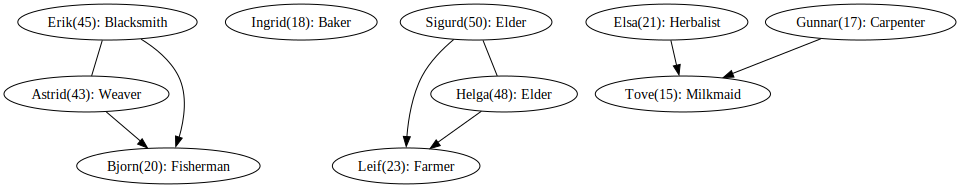

In [69]:
g = gv.Digraph()
g.graph_attr["rankdir"] = "TB"

for v in village.villagers:
    g.node(v.name, label=f"{v.name}({v.age}): {v.occupation}")

for r in village.relationships:
    arrowhead = "normal" if r.type == RelationshipType.PARENT_OF else "none"
    g.edge(head_name=r.object_name, tail_name=r.subject_name, arrowhead=arrowhead)

g

## Combining Pandas and Graphviz

In [15]:
import json
from IPython.display import JSON

ARROW_STYLE_LOOKUP = {
    RelationshipType.SPOUSE_OF: "none",
}

STYLE_LOOKUP = {
    RelationshipType.SPOUSE_OF: "bold",
}


def display_village(village: Village):
    # top level description of village
    village_info = json.loads(village.model_dump_json())

    # the table of villagers
    df = pd.DataFrame(map(BaseModel.model_dump, village.villagers)).set_index("name")

    g = gv.Digraph()
    g.graph_attr["rankdir"] = "TB"

    # the family trees of villagers
    for v in village.villagers:
        g.node(v.name, label=f"{v.name}({v.age}): {v.occupation}")

    for r in village.relationships:
        g.edge(
            head_name=r.object_name,
            tail_name=r.subject_name,
            arrowhead=ARROW_STYLE_LOOKUP.get(r.type, "normal"),
            style=STYLE_LOOKUP.get(r.type, "solid"),
        )

    display(JSON(village_info), df, g)

<IPython.core.display.JSON object>

,age,sex,occupation,ethnicity
name,,,,
Aldred,60,male,farmer,Saxon
Ealhswith,58,female,housewife,Saxon
Edgar,35,male,blacksmith,Saxon
Aelfgifu,32,female,weaver,Saxon
Hilda,10,female,student,Saxon
Godric,8,male,student,Saxon
Aethelred,45,male,miller,Saxon
Ealdgyth,42,female,baker,Saxon
Leofric,20,male,carpenter,Saxon


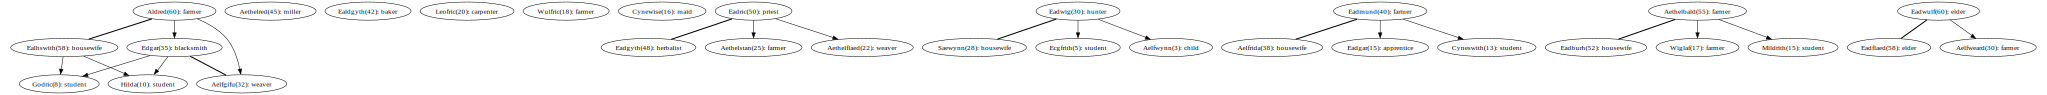

In [19]:
display_village(village=village)

## Chains

These steps can be combined in single chain object.

In [22]:
prompt = PromptTemplate(
    template=PROMPT_FORMAT_FOR_PARSING,
    input_variables=["location", "year", "population"],
    partial_variables={
        "format_instructions": pydantic_parser.get_format_instructions()
    },
)
chain = LLMChain(llm=llm, prompt=prompt, output_parser=pydantic_parser, verbose=True)

In [23]:
village = chain.run(location="Hertfordshire, England", year=1086, population=30)
village



> Entering new LLMChain chain...
Prompt after formatting:

Create a village in Hertfordshire, England in the year 1086. Describe 30 villagers along with their family relations to one another.

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"$defs": {"Relationship": {"properties": {"subject_name": {"default": "the subject of the relationship (e.g. Jane, subject, is a sibling of Sam, object.)", "title": "Subject Name", "type": "string"}, "object_name": {"default": "the object of the relationship (e.g. Jane, subject, is a sibling of Sam, object.)", "title": "Object Name", "type": "string"}

Village(name='Bramley', description='A small village in Hertfordshire, England.', county='Hertfordshire', year=1086, villagers=[Villager(name='Harold', age=45, sex='M', occupation='Blacksmith', ethnicity='Anglo-Saxon'), Villager(name='Edith', age=40, sex='F', occupation='Homemaker', ethnicity='Anglo-Saxon'), Villager(name='William', age=20, sex='M', occupation='Farmer', ethnicity='Anglo-Saxon'), Villager(name='Emma', age=18, sex='F', occupation='Weaver', ethnicity='Anglo-Saxon'), Villager(name='Alfred', age=17, sex='M', occupation='Apprentice', ethnicity='Anglo-Saxon'), Villager(name='Matilda', age=45, sex='F', occupation='Baker', ethnicity='Anglo-Saxon'), Villager(name='Robert', age=50, sex='M', occupation='Merchant', ethnicity='Anglo-Saxon'), Villager(name='Eleanor', age=48, sex='F', occupation='Homemaker', ethnicity='Anglo-Saxon'), Villager(name='Richard', age=30, sex='M', occupation='Carpenter', ethnicity='Anglo-Saxon'), Villager(name='Alice', age=28, sex='F', occupation='Homemaker

<IPython.core.display.JSON object>

,age,sex,occupation,ethnicity
name,,,,
Aldred,60,male,farmer,Saxon
Ealhswith,58,female,housewife,Saxon
Edgar,35,male,blacksmith,Saxon
Aelfgifu,32,female,weaver,Saxon
Hilda,10,female,student,Saxon
Godric,8,male,student,Saxon
Aethelred,45,male,miller,Saxon
Ealdgyth,42,female,baker,Saxon
Leofric,20,male,carpenter,Saxon


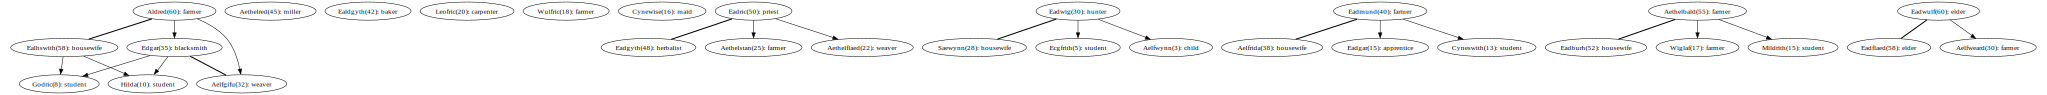

In [18]:
display_village(village=village)

# Final Comments
- Hard to get `ChatGPT` to give you what you want and ask for.
    - For higher numbers of villagers, will often shorten the list even though there should be plenty of tokens left.
- Can sometimes include "Sure! Here you go..." type verbage that makes it difficult to parse outputs.
    - Will often ignore requests to not do so.
- While this may be useful for fixtures in unit testing and other small applications, this may be limitted when larger, richer fake datasets are needed.